In [ ]:
import requests
import pandas as pd
import time
import json
import os
from datetime import datetime

# Constants for James Harden
HARDEN_ID = '201935'  # As string for API calls
HARDEN_ID_INT = 201935  # As integer for data filtering
ROCKETS_ID = '1610612745'
SEASONS = ['2016-17', '2017-18']

def get_nba_data(endpoint, params=None, retry_count=3):
    """
    Function to make requests to the NBA Stats API with proper headers, error handling and retry logic
    """
    base_url = "https://stats.nba.com/stats/"

    # Try different User-Agent strings to avoid blocking
    user_agents = [
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:72.0) Gecko/20100101 Firefox/72.0',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36 Edg/91.0.864.59',
        'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36'
    ]

    headers = {
        'Host': 'stats.nba.com',
        'User-Agent': user_agents[retry_count % len(user_agents)],
        'Accept': 'application/json, text/plain, */*',
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'x-nba-stats-origin': 'stats',
        'x-nba-stats-token': 'true',
        'Connection': 'keep-alive',
        'Referer': 'https://stats.nba.com/',
        'Pragma': 'no-cache',
        'Cache-Control': 'no-cache',
        'Origin': 'https://stats.nba.com'
    }

    url = f"{base_url}{endpoint}"

    # Add delay to avoid rate limiting - increase delay with each retry
    time.sleep(2 + (3 - retry_count))

    try:
        response = requests.get(url, headers=headers, params=params, timeout=30)

        # If we get a 429 (Too Many Requests) or 500, retry with backoff
        if response.status_code in [429, 500, 502, 503, 504] and retry_count > 0:
            print(f"Got status {response.status_code}. Retrying in {4 - retry_count} seconds...")
            time.sleep(4 - retry_count)
            return get_nba_data(endpoint, params, retry_count - 1)

        response.raise_for_status()  # Raise an exception for other 4XX/5XX responses

        # Check if response contains valid JSON
        if response.text.strip():
            return response.json()
        else:
            print(f"Empty response received from {url}")
            return None

    except requests.exceptions.RequestException as e:
        if retry_count > 0:
            print(f"Request failed: {e}. Retrying ({retry_count} attempts left)...")
            time.sleep(4 - retry_count)
            return get_nba_data(endpoint, params, retry_count - 1)
        else:
            print(f"Request failed after all retries: {e}")
            print(f"URL: {url}")
            print(f"Response status code: {response.status_code if 'response' in locals() else 'N/A'}")
            print(f"Response text: {response.text[:200] if 'response' in locals() else 'N/A'}...")
            return None
    except json.JSONDecodeError as e:
        if retry_count > 0:
            print(f"JSON decode error: {e}. Retrying ({retry_count} attempts left)...")
            time.sleep(4 - retry_count)
            return get_nba_data(endpoint, params, retry_count - 1)
        else:
            print(f"JSON decode error after all retries: {e}")
            print(f"Response text: {response.text[:200]}...")
            return None

def get_harden_shot_data(season):
    """Get all of James Harden's shots for a given season with correct parameters"""
    params = {
        'PlayerID': HARDEN_ID,
        'TeamID': ROCKETS_ID,  # Houston Rockets
        'Season': season,
        'SeasonType': 'Regular Season',
        'ContextMeasure': 'FGA',
        'PlayerPosition': '',
        'DateFrom': '',
        'DateTo': '',
        'GameID': '',
        'GameSegment': '',
        'LastNGames': 0,
        'LeagueID': '00',
        'Location': '',
        'Month': 0,
        'OpponentTeamID': 0,
        'Outcome': '',
        'Period': 0,
        'Position': '',
        'RookieYear': '',
        'SeasonSegment': '',
        'VsConference': '',
        'VsDivision': ''
    }

    data = get_nba_data('shotchartdetail', params)

    if data and 'resultSets' in data and len(data['resultSets']) > 0:
        headers = data['resultSets'][0]['headers']
        shots = data['resultSets'][0]['rowSet']
        shots_df = pd.DataFrame(shots, columns=headers)

        # Add some derived features relevant for decision making
        if 'SHOT_CLOCK' in shots_df.columns:
            shots_df['SECONDS_LEFT'] = 24 - shots_df['SHOT_CLOCK']

        if 'SCORE_MARGIN' in shots_df.columns:
            shots_df['CLOSE_GAME'] = abs(shots_df['SCORE_MARGIN']) <= 5

        if 'PERIOD' in shots_df.columns and 'MINUTES_REMAINING' in shots_df.columns:
            shots_df['TIME_PRESSURE'] = (shots_df['PERIOD'] >= 4) & (shots_df['MINUTES_REMAINING'] <= 2)

        # Add season column
        shots_df['SEASON'] = season

        return shots_df
    return None

def get_harden_games(season):
    """Get all games James Harden played in during a given season"""
    params = {
        'PlayerID': HARDEN_ID,
        'Season': season,
        'SeasonType': 'Regular Season',
        'LeagueID': '00',
        'MeasureType': 'Base',
        'PerMode': 'PerGame'
    }

    data = get_nba_data('playergamelog', params)

    if data and 'resultSets' in data and len(data['resultSets']) > 0:
        headers = data['resultSets'][0]['headers']
        games = data['resultSets'][0]['rowSet']
        games_df = pd.DataFrame(games, columns=headers)

        # Sort by date
        if 'GAME_DATE' in games_df.columns:
            games_df['GAME_DATE'] = pd.to_datetime(games_df['GAME_DATE'])
            games_df = games_df.sort_values('GAME_DATE')

        # Add season column
        games_df['SEASON'] = season

        return games_df
    return None

def get_boxscore_advanced(game_id):
    """Get advanced stats for a specific game using the v3 endpoint"""
    params = {
        'GameID': game_id,
        'StartPeriod': 1,
        'EndPeriod': 4,
        'StartRange': 0,
        'EndRange': 0,
        'RangeType': 0
    }

    data = get_nba_data('boxscoreadvancedv3', params)

    # Based on the class definition you provided:
    if data and 'PlayerStats' in data:
        # Convert to DataFrame
        df = pd.DataFrame(data['PlayerStats'])

        # Filter for Harden
        if 'personId' in df.columns:
            harden_df = df[df['personId'] == HARDEN_ID_INT].copy()

            # Add game ID if it doesn't exist
            if 'gameId' not in harden_df.columns:
                harden_df['gameId'] = game_id

            return harden_df

    # Fallback to old structure if needed
    elif data and 'resultSets' in data and len(data['resultSets']) > 0:
        headers = data['resultSets'][0]['headers']
        rows = data['resultSets'][0]['rowSet']
        df = pd.DataFrame(rows, columns=headers)

        # Try to find Harden based on different possible column names
        harden_df = None

        if 'PLAYER_ID' in df.columns:
            harden_df = df[df['PLAYER_ID'] == HARDEN_ID].copy()
        elif 'PLAYER_NAME' in df.columns:
            harden_df = df[df['PLAYER_NAME'].str.contains('Harden', na=False)].copy()

        if harden_df is not None and len(harden_df) > 0:
            # Add game ID
            harden_df['GAME_ID'] = game_id
            return harden_df

    print(f"Could not find Harden in boxscoreadvancedv3 data for game {game_id}")
    return None

def get_boxscore_tracking(game_id):
    """Get player tracking data for a specific game using the v3 endpoint"""
    params = {
        'GameID': game_id
    }

    data = get_nba_data('boxscoreplayertrackv3', params)

    # Based on the class definition you provided:
    if data and 'PlayerStats' in data:
        # Convert to DataFrame
        df = pd.DataFrame(data['PlayerStats'])

        # Filter for Harden
        if 'personId' in df.columns:
            harden_df = df[df['personId'] == HARDEN_ID_INT].copy()

            # Add game ID if it doesn't exist
            if 'gameId' not in harden_df.columns:
                harden_df['gameId'] = game_id

            return harden_df

    # Fallback to old structure if needed
    elif data and 'resultSets' in data and len(data['resultSets']) > 0:
        headers = data['resultSets'][0]['headers']
        rows = data['resultSets'][0]['rowSet']
        df = pd.DataFrame(rows, columns=headers)

        # Try to find Harden based on different possible column names
        harden_df = None

        if 'PLAYER_ID' in df.columns:
            harden_df = df[df['PLAYER_ID'] == HARDEN_ID].copy()
        elif 'PLAYER_NAME' in df.columns:
            harden_df = df[df['PLAYER_NAME'].str.contains('Harden', na=False)].copy()

        if harden_df is not None and len(harden_df) > 0:
            # Add game ID
            harden_df['GAME_ID'] = game_id
            return harden_df

    print(f"Could not find Harden in boxscoreplayertrackv3 data for game {game_id}")
    return None

def get_harden_playbyplay_for_game(game_id):
    """Get all plays involving James Harden for a specific game"""
    params = {
        'GameID': game_id,
        'StartPeriod': 0,
        'EndPeriod': 10,
        'StartRange': 0,
        'EndRange': 55800,
        'RangeType': 2
    }

    data = get_nba_data('playbyplayv2', params)

    if data and 'resultSets' in data and len(data['resultSets']) > 0:
        headers = data['resultSets'][0]['headers']
        plays = data['resultSets'][0]['rowSet']
        plays_df = pd.DataFrame(plays, columns=headers)

        # Filter for plays involving Harden
        if 'PLAYER1_NAME' in plays_df.columns and 'PLAYER2_NAME' in plays_df.columns and 'PLAYER3_NAME' in plays_df.columns:
            harden_plays = plays_df[
                plays_df['PLAYER1_NAME'].str.contains('Harden', na=False) |
                plays_df['PLAYER2_NAME'].str.contains('Harden', na=False) |
                plays_df['PLAYER3_NAME'].str.contains('Harden', na=False)
            ].copy()

            # Add game ID as a column
            harden_plays['GAME_ID'] = game_id

            return harden_plays
    return None

def collect_harden_data(season, max_games=10):
    """Collect all available data for James Harden for a specific season"""
    print(f"\n{'='*50}")
    print(f"COLLECTING DATA FOR JAMES HARDEN'S {season} SEASON")
    print(f"{'='*50}\n")

    # Create season-specific directory
    season_dir = f"harden_data/{season.replace('-', '_')}"
    if not os.path.exists(season_dir):
        os.makedirs(season_dir)

    # Shot data
    print(f"Getting shot data for {season}...")
    shots_df = get_harden_shot_data(season)
    if shots_df is not None:
        print(f"Retrieved {len(shots_df)} shots.")
        shots_df.to_csv(f"{season_dir}/harden_{season}_shots.csv", index=False)
    else:
        print(f"Failed to retrieve shot data for {season}.")

    # Game log
    print(f"\nGetting game log for {season}...")
    games_df = get_harden_games(season)
    if games_df is not None:
        print(f"Retrieved {len(games_df)} games.")
        games_df.to_csv(f"{season_dir}/harden_{season}_games.csv", index=False)

        # Get advanced stats, tracking data, and play-by-play for each game
        all_pbp = []
        all_adv = []
        all_track = []

        print(f"\nGetting game-level data for {season}...")

        # Option to limit games for testing or if running into API issues
        max_game_count = min(max_games, len(games_df))
        print(f"Processing {max_game_count} games for detailed analysis...")

        if not games_df.empty:
            print("Game log columns:", list(games_df.columns))

        for i, (_, game) in enumerate(games_df.iloc[:max_game_count].iterrows()):
            # Get game ID using various possible column names
            game_id = None

            # First check all possible column names for game ID
            for col_name in ['Game_ID', 'GAME_ID', 'GameID', 'game_id']:
                if col_name in game and pd.notna(game[col_name]):
                    game_id = str(game[col_name])
                    break

            if game_id is None:
                print(f"Could not find game ID in row: {game.to_dict()}")
                continue

            print(f"  Processing game {i+1}/{max_game_count}: {game_id}...")

            # Get advanced box score
            adv_df = get_boxscore_advanced(game_id)
            if adv_df is not None:
                all_adv.append(adv_df)
                adv_df.to_csv(f"{season_dir}/harden_game_{game_id}_advanced.csv", index=False)
                print(f"    Retrieved advanced stats for game {game_id}")

            # Get tracking data
            track_df = get_boxscore_tracking(game_id)
            if track_df is not None:
                all_track.append(track_df)
                track_df.to_csv(f"{season_dir}/harden_game_{game_id}_tracking.csv", index=False)
                print(f"    Retrieved tracking data for game {game_id}")

            # Get play-by-play
            pbp_df = get_harden_playbyplay_for_game(game_id)
            if pbp_df is not None:
                all_pbp.append(pbp_df)
                pbp_df.to_csv(f"{season_dir}/harden_game_{game_id}_pbp.csv", index=False)
                print(f"    Retrieved {len(pbp_df)} Harden-related plays for game {game_id}")

            # Add delay to avoid API limits
            time.sleep(2)

        # Combine all data
        if all_pbp:
            combined_pbp = pd.concat(all_pbp)
            print(f"Retrieved {len(combined_pbp)} total Harden-related plays for {season}.")
            combined_pbp.to_csv(f"{season_dir}/harden_{season}_playbyplay.csv", index=False)

        if all_adv:
            combined_adv = pd.concat(all_adv)
            print(f"Retrieved advanced stats for {len(combined_adv)} games for {season}.")
            combined_adv.to_csv(f"{season_dir}/harden_{season}_game_advanced.csv", index=False)

        if all_track:
            combined_track = pd.concat(all_track)
            print(f"Retrieved tracking data for {len(combined_track)} games for {season}.")
            combined_track.to_csv(f"{season_dir}/harden_{season}_game_tracking.csv", index=False)
    else:
        print(f"Failed to retrieve game data for {season}.")

    print(f"\nCompleted data collection for {season} season.")

def collect_all_seasons_data():
    """Collect data for all specified seasons"""
    print("Starting data collection for James Harden...")

    # Create a data directory if it doesn't exist
    if not os.path.exists("harden_data"):
        os.makedirs("harden_data")

    # Process each season
    for season in SEASONS:
        collect_harden_data(season, max_games=10)

    print("\nData collection complete for all seasons.")
    print("\nCollected data:")
    print("1. Shot data - location, distance, game context")
    print("2. Game log - basic stats for all games")
    print("3. Game-level advanced stats - offensive/defensive ratings, usage, etc.")
    print("4. Game-level tracking data - speed, distance, passing, contested shots")
    print("5. Play-by-play data - detailed sequence of actions")

if __name__ == "__main__":
    collect_all_seasons_data()

Starting data collection for James Harden...

COLLECTING DATA FOR JAMES HARDEN'S 2016-17 SEASON

Getting shot data for 2016-17...
Retrieved 1531 shots.

Getting game log for 2016-17...
Retrieved 81 games.

Getting game-level data for 2016-17...
Processing 10 games for detailed analysis...
Game log columns: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'SEASON']
  Processing game 1/10: 0021600013...
Could not find Harden in boxscoreadvancedv3 data for game 0021600013
Could not find Harden in boxscoreplayertrackv3 data for game 0021600013
    Retrieved 87 Harden-related plays for game 0021600013
  Processing game 2/10: 0021600023...
Could not find Harden in boxscoreadvancedv3 data for game 0021600023
Could not find Harden in boxscoreplayertrackv3 data for game 0021600023
    Retrieved 54 Ha

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create directory for saving results
os.makedirs('harden_analysis', exist_ok=True)

# Display versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")

TensorFlow version: 2.18.0
Pandas version: 2.2.2



===== DECISION PATTERN ANALYSIS =====

Shot Type Selection by Period (%):
SHOT_TYPE  2PT Field Goal  3PT Field Goal
PERIOD                                   
1                    54.1            45.9
2                    52.4            47.6
3                    48.1            51.9
4                    46.5            53.5
5                    72.7            27.3
6                    25.0            75.0


<Figure size 1000x600 with 0 Axes>

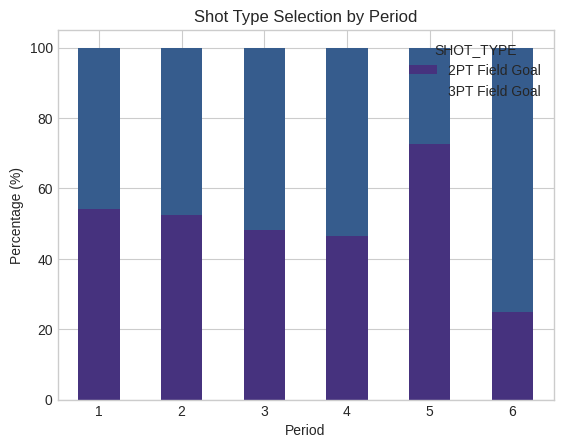


Step-Back Usage by Period (%):
PERIOD
1    11.9
2    15.2
3    13.2
4    17.7
5    27.3
6     0.0
Name: 1, dtype: float64


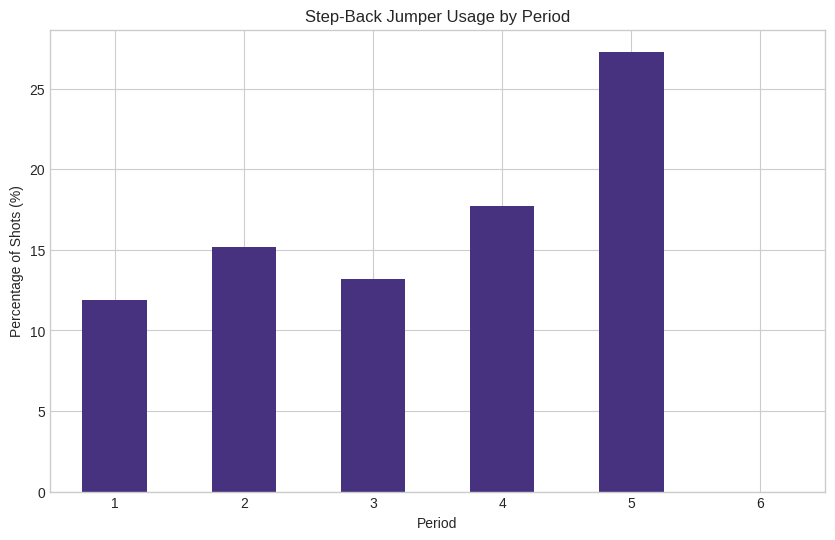

In [ ]:
def analyze_decision_patterns(shots_df):
    """Analyze key decision patterns in Harden's game"""
    if shots_df is None:
        return None

    print("\n===== DECISION PATTERN ANALYSIS =====")

    # Ensure numeric columns
    shots = shots_df.copy()
    for col in ['SHOT_DISTANCE', 'PERIOD', 'SHOT_CLOCK', 'SCORE_MARGIN']:
        if col in shots.columns:
            shots[col] = pd.to_numeric(shots[col], errors='coerce')

    # 1. Analyze when Harden chooses 3PT vs 2PT shots based on game situation
    if all(col in shots.columns for col in ['PERIOD', 'SHOT_TYPE']):
        # Shot type by period
        period_shot_type = pd.crosstab(
            index=shots['PERIOD'],
            columns=shots['SHOT_TYPE'],
            normalize='index'
        ).mul(100).round(1)

        print("\nShot Type Selection by Period (%):")
        print(period_shot_type)

        # Visualize
        plt.figure(figsize=(10, 6))
        period_shot_type.plot(kind='bar', stacked=True)
        plt.title("Shot Type Selection by Period")
        plt.xlabel("Period")
        plt.ylabel("Percentage (%)")
        plt.xticks(rotation=0)
        plt.savefig("harden_analysis/shot_type_by_period.png")
        plt.show()

    # 2. Analyze shot selection by score margin
    if all(col in shots.columns for col in ['SCORE_MARGIN', 'SHOT_TYPE']):
        # Create score margin bins
        shots['SCORE_SITUATION'] = pd.cut(
            shots['SCORE_MARGIN'],
            bins=[-100, -10, -5, 0, 5, 10, 100],
            labels=[
                'Down big (>10)',
                'Down (5-10)',
                'Slightly behind (1-5)',
                'Slightly ahead (1-5)',
                'Ahead (5-10)',
                'Up big (>10)'
            ],
            include_lowest=True
        )

        # Create cross-tabulation
        margin_shot_type = pd.crosstab(
            index=shots['SCORE_SITUATION'],
            columns=shots['SHOT_TYPE'],
            normalize='index'
        ).mul(100).round(1)

        print("\nShot Type by Score Situation (%):")
        print(margin_shot_type)

        # Visualize
        plt.figure(figsize=(12, 6))
        margin_shot_type.plot(kind='bar', stacked=True)
        plt.title("Shot Type Selection by Score Margin")
        plt.xlabel("Game Situation")
        plt.ylabel("Percentage (%)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig("harden_analysis/shot_type_by_margin.png")
        plt.show()

    # 3. Analyze step-back usage (if data is available)
    if 'ACTION_TYPE' in shots.columns:
        # Identify step-back jumpers
        shots['IS_STEP_BACK'] = shots['ACTION_TYPE'].str.contains('Step Back', case=False, na=False).astype(int)

        # Step-back by period
        if 'PERIOD' in shots.columns:
            step_back_by_period = pd.crosstab(
                index=shots['PERIOD'],
                columns=shots['IS_STEP_BACK'],
                normalize='index'
            ).mul(100).round(1)

            if 1 in step_back_by_period.columns:
                print("\nStep-Back Usage by Period (%):")
                print(step_back_by_period[1])

                # Visualize
                plt.figure(figsize=(10, 6))
                step_back_by_period[1].plot(kind='bar')
                plt.title("Step-Back Jumper Usage by Period")
                plt.xlabel("Period")
                plt.ylabel("Percentage of Shots (%)")
                plt.xticks(rotation=0)
                plt.savefig("harden_analysis/step_back_by_period.png")
                plt.show()

    return shots

# Analyze decision patterns
analyzed_shots = analyze_decision_patterns(shots_df)

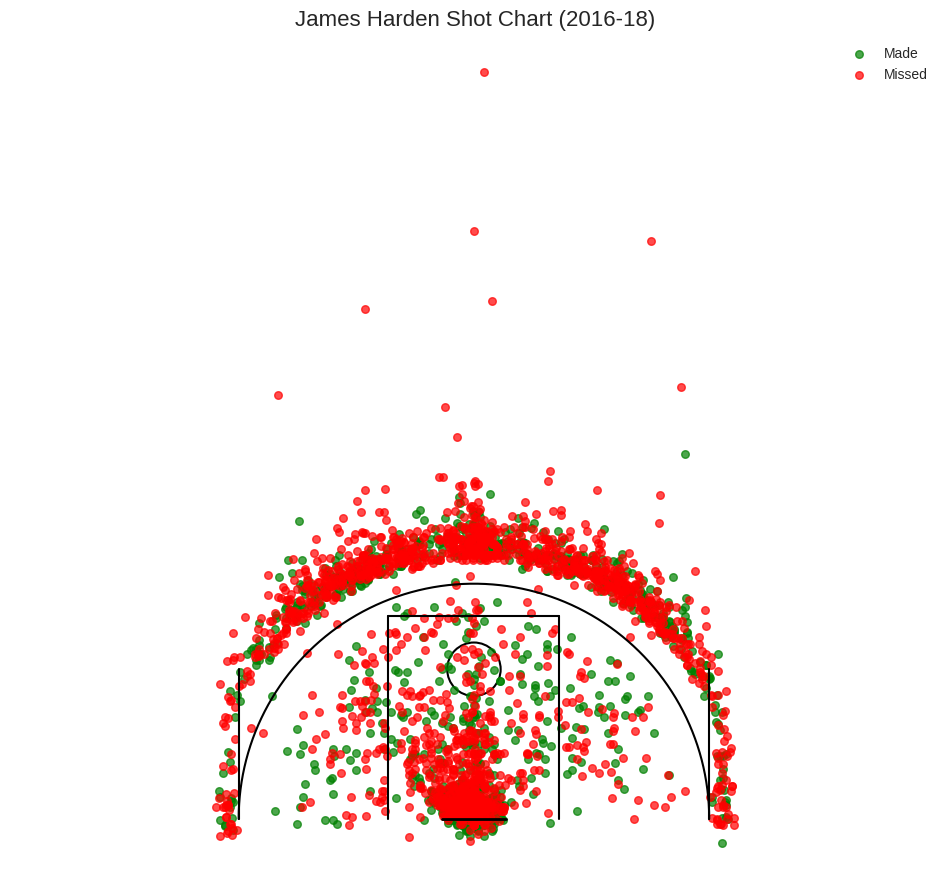

In [ ]:
def plot_shot_chart(shots_df, title="James Harden Shot Chart (2016-18)"):
    """Create a shot chart visualization"""
    if 'LOC_X' not in shots_df.columns or 'LOC_Y' not in shots_df.columns:
        print("Cannot create shot chart: missing location coordinates")
        return None

    # Set up the figure
    plt.figure(figsize=(12, 11))

    # Draw a simple court
    # Center circle
    center_circle = plt.Circle((0, 140), 25, fill=False, color='black', linewidth=1.5)
    plt.gca().add_patch(center_circle)

    # Hoop
    hoop = plt.Circle((0, 0), 7.5, fill=False, color='black', linewidth=2)
    plt.gca().add_patch(hoop)

    # Backboard
    plt.plot([-30, 30], [0, 0], 'k-', linewidth=2)

    # 3-point line
    plt.plot([-220, -220], [0, 140], 'k-', linewidth=1.5)  # Left line
    plt.plot([220, 220], [0, 140], 'k-', linewidth=1.5)    # Right line

    # Arc of 3pt line (approximation)
    theta = np.linspace(0, np.pi, 100)
    x = 220 * np.cos(theta)
    y = 220 * np.sin(theta)
    plt.plot(x, y, 'k-', linewidth=1.5)

    # Paint
    plt.plot([-80, -80], [0, 190], 'k-', linewidth=1.5)
    plt.plot([80, 80], [0, 190], 'k-', linewidth=1.5)
    plt.plot([-80, 80], [190, 190], 'k-', linewidth=1.5)

    # Plot shots
    if 'SHOT_MADE_FLAG' in shots_df.columns:
        made_mask = shots_df['SHOT_MADE_FLAG'] == 1
        plt.scatter(
            shots_df.loc[made_mask, 'LOC_X'],
            shots_df.loc[made_mask, 'LOC_Y'],
            c='green', alpha=0.7, s=30, label='Made'
        )
        plt.scatter(
            shots_df.loc[~made_mask, 'LOC_X'],
            shots_df.loc[~made_mask, 'LOC_Y'],
            c='red', alpha=0.7, s=30, label='Missed'
        )
    else:
        plt.scatter(shots_df['LOC_X'], shots_df['LOC_Y'], alpha=0.7, s=30)

    # Set limits and title
    plt.xlim(-300, 300)
    plt.ylim(-50, 300)
    plt.title(title, fontsize=16)
    plt.legend(loc='upper right')
    plt.axis('equal')
    plt.axis('off')

    plt.savefig("harden_analysis/shot_chart.png", dpi=300, bbox_inches='tight')
    plt.show()

# Create the shot chart
plot_shot_chart(shots_df)

In [ ]:
def load_harden_data(seasons=['2016_17', '2017_18']):
    """Load James Harden data for given seasons"""
    all_shots = []
    all_games = []
    all_pbp = []

    for season in seasons:
        season_dir = f"harden_data/{season}"
        season_str = season.replace('_', '-')

        # Load shots data
        shots_path = f"{season_dir}/harden_{season_str}_shots.csv"
        if os.path.exists(shots_path):
            shots = pd.read_csv(shots_path)
            shots['SEASON'] = season_str
            all_shots.append(shots)
            print(f"Loaded {len(shots)} shots from {season}")

        # Load games data
        games_path = f"{season_dir}/harden_{season_str}_games.csv"
        if os.path.exists(games_path):
            games = pd.read_csv(games_path)
            games['SEASON'] = season_str
            all_games.append(games)
            print(f"Loaded {len(games)} games from {season}")

        # Load play-by-play data
        pbp_path = f"{season_dir}/harden_{season_str}_playbyplay.csv"
        if os.path.exists(pbp_path):
            pbp = pd.read_csv(pbp_path)
            pbp['SEASON'] = season_str
            all_pbp.append(pbp)
            print(f"Loaded {len(pbp)} play-by-play events from {season}")

    # Combine the data
    shots_df = pd.concat(all_shots, ignore_index=True) if all_shots else None
    games_df = pd.concat(all_games, ignore_index=True) if all_games else None
    pbp_df = pd.concat(all_pbp, ignore_index=True) if all_pbp else None

    print("\nCombined data summary:")
    print(f"Total shots: {len(shots_df) if shots_df is not None else 0}")
    print(f"Total games: {len(games_df) if games_df is not None else 0}")
    print(f"Total play-by-play events: {len(pbp_df) if pbp_df is not None else 0}")

    return shots_df, games_df, pbp_df

# Load the data
shots_df, games_df, pbp_df = load_harden_data()

Loaded 1531 shots from 2016_17
Loaded 81 games from 2016_17
Loaded 681 play-by-play events from 2016_17
Loaded 1449 shots from 2017_18
Loaded 72 games from 2017_18
Loaded 601 play-by-play events from 2017_18

Combined data summary:
Total shots: 2980
Total games: 153
Total play-by-play events: 1282


In [31]:
def engineer_shot_features(shots_df):
    """Create features for machine learning from shot data"""
    if shots_df is None:
        return None

    print("Engineering features for ML models...")
    # Make a copy to avoid modifying the original
    model_data = shots_df.copy()

    # Convert necessary columns to numeric
    numeric_cols = ['SHOT_DISTANCE', 'PERIOD', 'MINUTES_REMAINING',
                    'SECONDS_REMAINING', 'SHOT_CLOCK', 'SCORE_MARGIN']

    for col in numeric_cols:
        if col in model_data.columns:
            model_data[col] = pd.to_numeric(model_data[col], errors='coerce')

    # Distance-based features
    if 'SHOT_DISTANCE' in model_data.columns:
        model_data['AT_RIM'] = (model_data['SHOT_DISTANCE'] <= 3).astype(int)
        model_data['SHORT_MID'] = ((model_data['SHOT_DISTANCE'] > 3) &
                                  (model_data['SHOT_DISTANCE'] <= 10)).astype(int)
        model_data['MID_RANGE'] = ((model_data['SHOT_DISTANCE'] > 10) &
                                  (model_data['SHOT_DISTANCE'] <= 20)).astype(int)
        model_data['THREE_POINT_RANGE'] = (model_data['SHOT_DISTANCE'] > 20).astype(int)

    # Court location features
    if all(col in model_data.columns for col in ['LOC_X', 'LOC_Y']):
        model_data['LEFT_SIDE'] = (model_data['LOC_X'] < -33).astype(int)
        model_data['RIGHT_SIDE'] = (model_data['LOC_X'] > 33).astype(int)
        model_data['CENTER'] = ((model_data['LOC_X'] >= -33) &
                               (model_data['LOC_X'] <= 33)).astype(int)
        model_data['BASELINE'] = (model_data['LOC_Y'] < 80).astype(int)

    # Game situation features
    if 'SCORE_MARGIN' in model_data.columns:
        model_data['LEADING'] = (model_data['SCORE_MARGIN'] > 0).astype(int)
        model_data['TRAILING'] = (model_data['SCORE_MARGIN'] < 0).astype(int)
        model_data['TIED'] = (model_data['SCORE_MARGIN'] == 0).astype(int)
        model_data['CLOSE_GAME'] = (model_data['SCORE_MARGIN'].abs() <= 5).astype(int)

    # Time features
    if 'PERIOD' in model_data.columns:
        model_data['FOURTH_QUARTER'] = (model_data['PERIOD'] == 4).astype(int)
        model_data['CLUTCH_SITUATION'] = (
            (model_data['PERIOD'] >= 4) &
            (model_data['MINUTES_REMAINING'] <= 5) &
            (model_data['SCORE_MARGIN'].abs() <= 5)
        ).astype(int) if 'MINUTES_REMAINING' in model_data.columns and 'SCORE_MARGIN' in model_data.columns else 0

    # Shot type features
    if 'ACTION_TYPE' in model_data.columns:
        # Step back jumpers
        model_data['IS_STEP_BACK'] = model_data['ACTION_TYPE'].str.contains('Step Back', case=False, na=False).astype(int)

        # Pull up jumpers
        model_data['IS_PULL_UP'] = model_data['ACTION_TYPE'].str.contains('Pull Up', case=False, na=False).astype(int)

        # Driving shots
        model_data['IS_DRIVING'] = model_data['ACTION_TYPE'].str.contains('Driving', case=False, na=False).astype(int)

    # Handle missing values
    numeric_cols = model_data.select_dtypes(include=['number']).columns
    model_data[numeric_cols] = model_data[numeric_cols].fillna(0)

    print(f"Created dataset with {len(model_data)} rows and {len(model_data.columns)} features")

    return model_data

# Engineer features for modeling
model_data = engineer_shot_features(shots_df)

Engineering features for ML models...
Created dataset with 2980 rows and 39 features



Building TensorFlow model to predict shot outcomes (make/miss)...
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5466 - loss: 0.7533 - val_accuracy: 0.5975 - val_loss: 0.6771
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6031 - loss: 0.6694 - val_accuracy: 0.5933 - val_loss: 0.6752
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6038 - loss: 0.6797 - val_accuracy: 0.5933 - val_loss: 0.6730
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6159 - loss: 0.6690 - val_accuracy: 0.5996 - val_loss: 0.6714
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6185 - loss: 0.6545 - val_accuracy: 0.6059 - val_loss: 0.6713
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6224 - loss: 0.6481 - val_accuracy: 0.6059 - val_loss: 0.6708
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6234 - loss: 0.6556 - val_accuracy: 0.6101 - val_loss: 0.6724
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

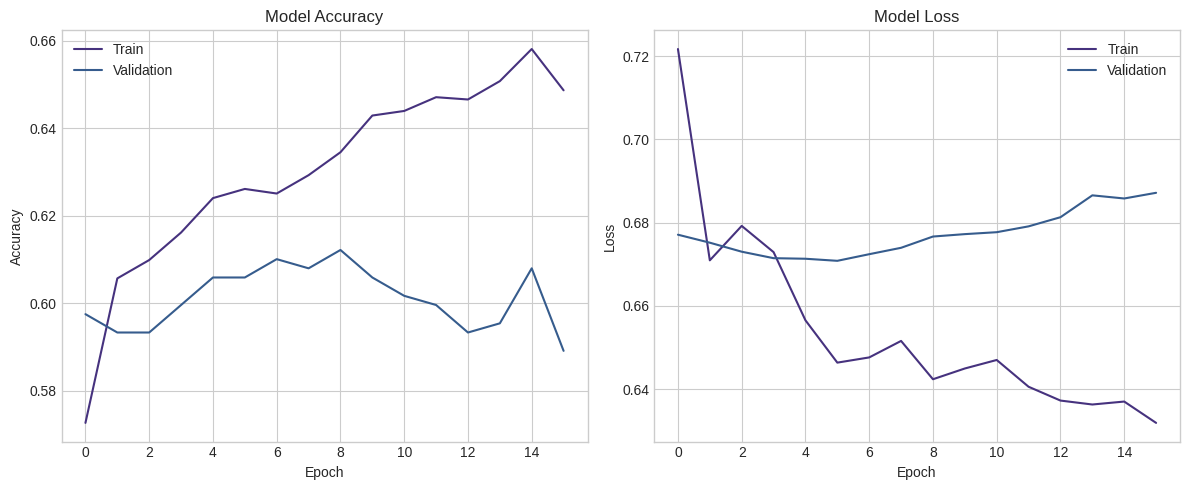


Top 10 Features for Shot Outcome Prediction:
              Feature  Importance
7           GAME_DATE    0.112012
16     FOURTH_QUARTER    0.104935
15           BASELINE    0.104623
2   SECONDS_REMAINING    0.104560
13         RIGHT_SIDE    0.104219
20         IS_DRIVING    0.101821
4               LOC_X    0.100408
8              AT_RIM    0.100288
11  THREE_POINT_RANGE    0.100208
0              PERIOD    0.099269


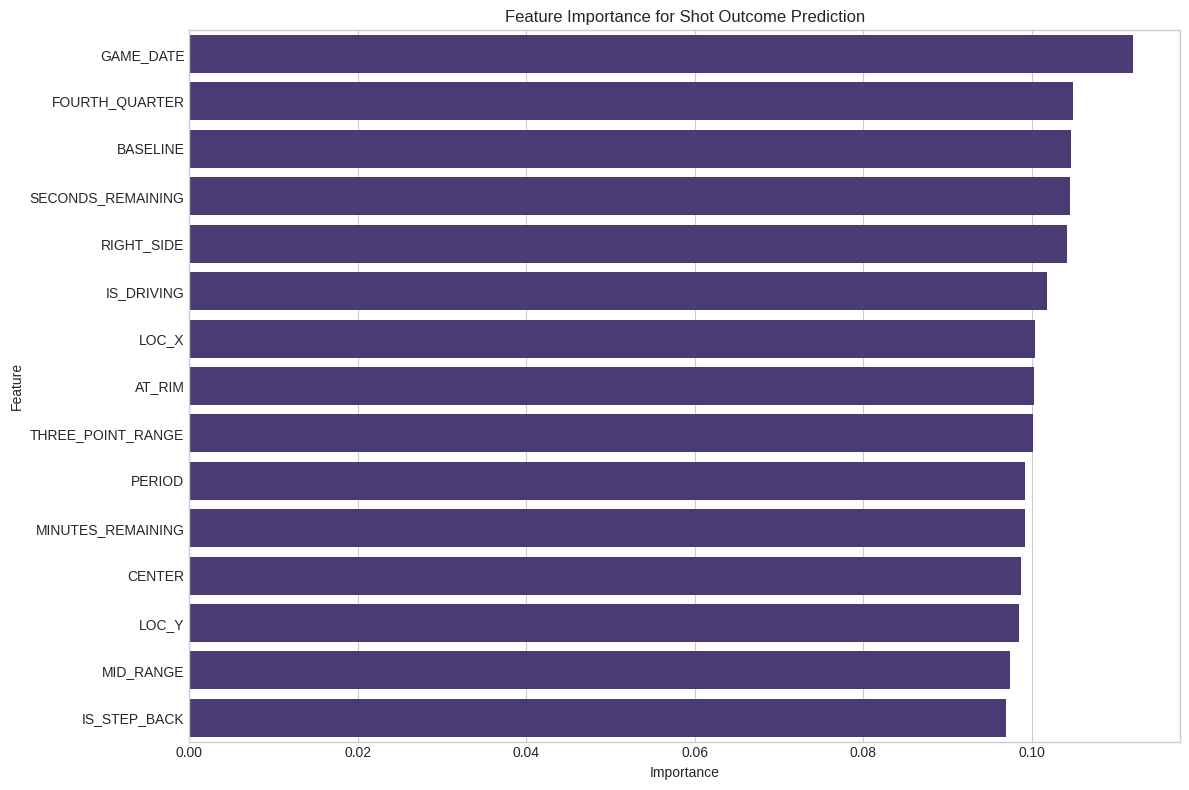

In [58]:
def build_shot_outcome_model(model_data):
    """Build TensorFlow model to predict shot outcomes (make vs miss)"""
    if 'SHOT_MADE_FLAG' not in model_data.columns:
        print("Cannot build model: missing SHOT_MADE_FLAG column")
        return None

    print("\nBuilding TensorFlow model to predict shot outcomes (make/miss)...")

    # Define target and features
    y = model_data['SHOT_MADE_FLAG']

    # Select only numeric features
    X = model_data.select_dtypes(include=['number'])

    # Remove target and ID columns
    exclude_cols = ['SHOT_MADE_FLAG', 'GAME_ID', 'PLAYER_ID', 'TEAM_ID', 'GAME_EVENT_ID']
    feature_cols = [col for col in X.columns if col not in exclude_cols]
    X = X[feature_cols]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build the model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=64,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        verbose=1
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_scaled, y_test)
    print(f"\nTest accuracy: {accuracy:.4f}")

    # Make predictions
    y_pred_prob = model.predict(X_test_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.savefig('harden_analysis/shot_outcome_model.png')
    plt.show()

    # Feature importance analysis
    weights = model.layers[0].get_weights()[0]
    importance = np.abs(weights).mean(axis=1)

    # Create a DataFrame with feature importances
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    # Print and plot top features
    print("\nTop 10 Features for Shot Outcome Prediction:")
    print(feature_importance.head(10))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Feature Importance for Shot Outcome Prediction')
    plt.tight_layout()
    plt.savefig('harden_analysis/shot_outcome_features.png')
    plt.show()

    return model, feature_importance

# Build the shot outcome model
shot_outcome_model, shot_importance = build_shot_outcome_model(model_data)


Building TensorFlow model to predict shot type selection (3PT vs 2PT)...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8151 - loss: 0.4350 - val_accuracy: 0.9804 - val_loss: 0.2409
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9751 - loss: 0.0958 - val_accuracy: 0.9958 - val_loss: 0.0883
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9873 - loss: 0.0458 - val_accuracy: 0.9958 - val_loss: 0.0427
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9945 - loss: 0.0310 - val_accuracy: 0.9958 - val_loss: 0.0297
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9923 - loss: 0.0335 - val_accuracy: 0.9958 - val_loss: 0.0253
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9956 - loss: 0.0212 - val_accuracy: 0.9958 - val_loss: 0.0239
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9962 - loss: 0.0205 - val_accuracy: 0.9958 - val_loss: 0.0234
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9961 - loss: 0.0187 - val_accuracy: 0.9958 - val_loss: 0.0245
Ep

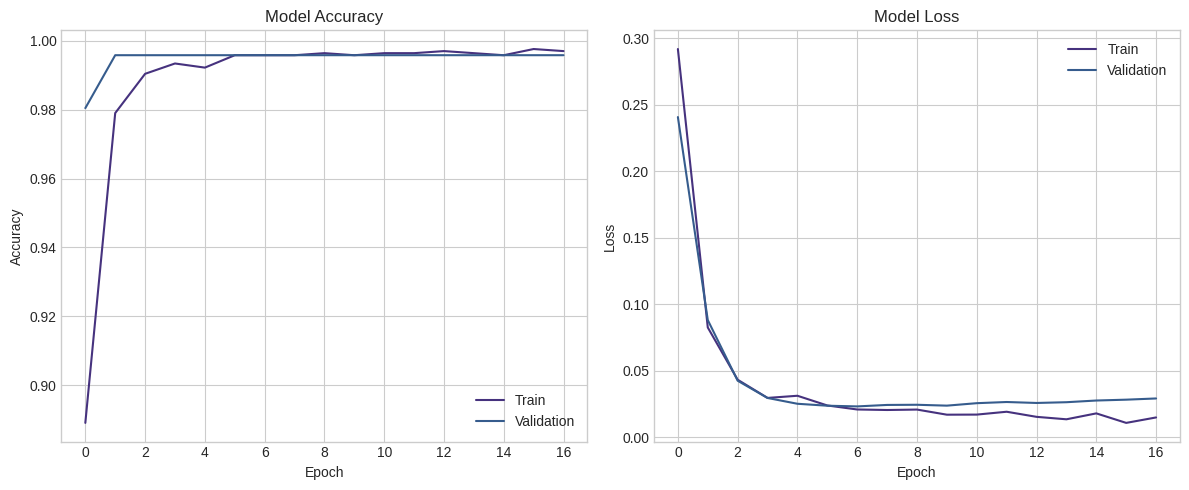


Top 10 Features for Shot Type Selection:
             Feature  Importance
9          MID_RANGE    0.115789
7             AT_RIM    0.110891
13          BASELINE    0.110666
15  CLUTCH_SITUATION    0.109577
17        IS_PULL_UP    0.107967
3              LOC_X    0.105799
8          SHORT_MID    0.105495
4              LOC_Y    0.105130
18        IS_DRIVING    0.105084
11        RIGHT_SIDE    0.104104


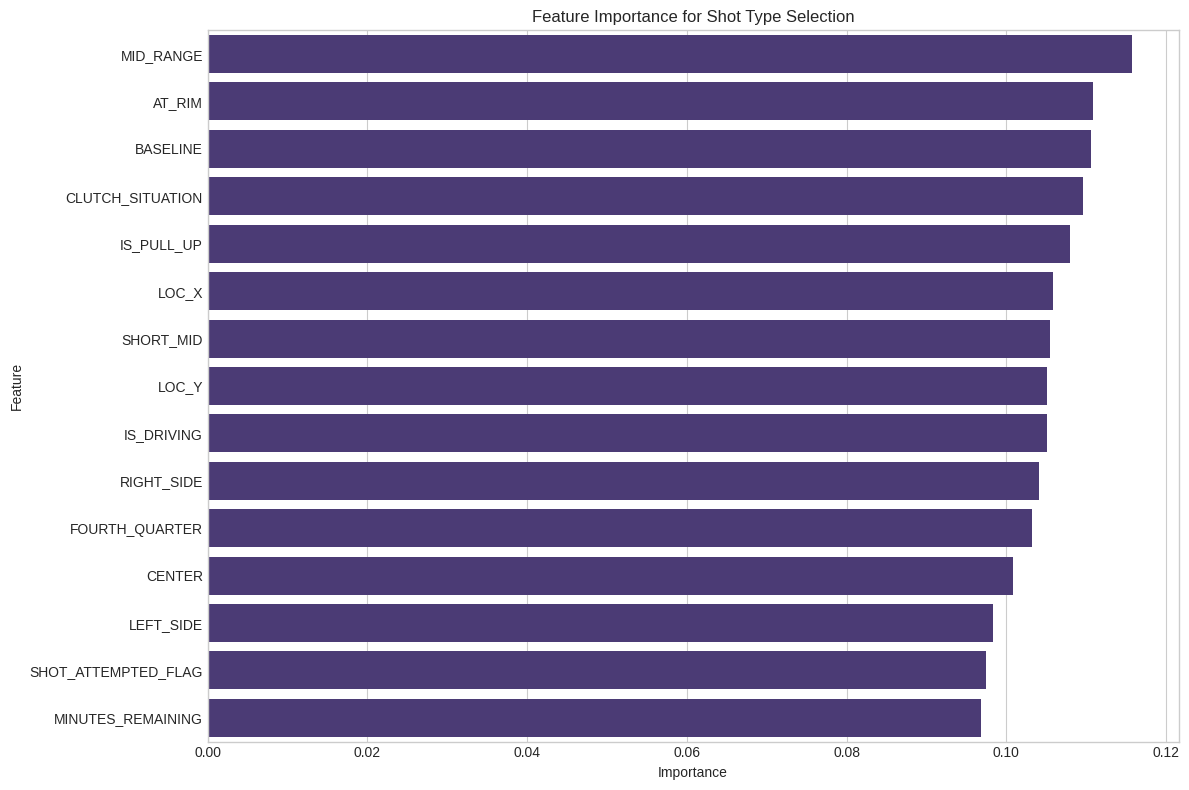

In [35]:
def build_shot_type_model(model_data):
    """Build TensorFlow model to predict shot type selection (3PT vs 2PT)"""
    if 'SHOT_TYPE' not in model_data.columns:
        print("Cannot build model: missing SHOT_TYPE column")
        return None

    print("\nBuilding TensorFlow model to predict shot type selection (3PT vs 2PT)...")

    # Create target variable
    model_data['IS_THREE'] = (model_data['SHOT_TYPE'] == '3PT Field Goal').astype(int)

    # Define target and features
    y = model_data['IS_THREE']

    # Select only numeric features
    X = model_data.select_dtypes(include=['number'])

    # Remove target and related variables
    exclude_cols = ['IS_THREE', 'IS_THREE_POINTER', 'THREE_POINT_RANGE', 'SHOT_MADE_FLAG',
                    'GAME_ID', 'PLAYER_ID', 'TEAM_ID', 'GAME_EVENT_ID', 'SHOT_DISTANCE']

    feature_cols = [col for col in X.columns if col not in exclude_cols]
    X = X[feature_cols]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build the model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.3,
        epochs=50,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        verbose=1
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_scaled, y_test)
    print(f"\nTest accuracy: {accuracy:.4f}")

    # Make predictions
    y_pred_prob = model.predict(X_test_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.savefig('harden_analysis/shot_selection_model.png')
    plt.show()

    # Feature importance analysis
    weights = model.layers[0].get_weights()[0]
    importance = np.abs(weights).mean(axis=1)

    # Create a DataFrame with feature importances
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    # Print and plot top features
    print("\nTop 10 Features for Shot Type Selection:")
    print(feature_importance.head(10))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Feature Importance for Shot Type Selection')
    plt.tight_layout()
    plt.savefig('harden_analysis/shot_selection_features.png')
    plt.show()

    return model, feature_importance

# Build the shot type selection model
shot_type_model, type_importance = build_shot_type_model(model_data)


Building model to predict step-back jumper usage (found 423 instances)...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5629 - loss: 0.6882 - val_accuracy: 0.6101 - val_loss: 0.6509
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6121 - loss: 0.6228 - val_accuracy: 0.6289 - val_loss: 0.5983
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6417 - loss: 0.5824 - val_accuracy: 0.6646 - val_loss: 0.5509
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6449 - loss: 0.5491 - val_accuracy: 0.6688 - val_loss: 0.5338
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6743 - loss: 0.5238 - val_accuracy: 0.6730 - val_loss: 0.5177
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6865 - loss: 0.4852 - val_accuracy: 0.6625 - val_loss: 0.5140
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6794 - loss: 0.4896 - val_accuracy: 0.6709 - val_loss: 0.5055
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6935 - loss: 0.4840 - val_accuracy: 0.6604 - val_loss: 0.5

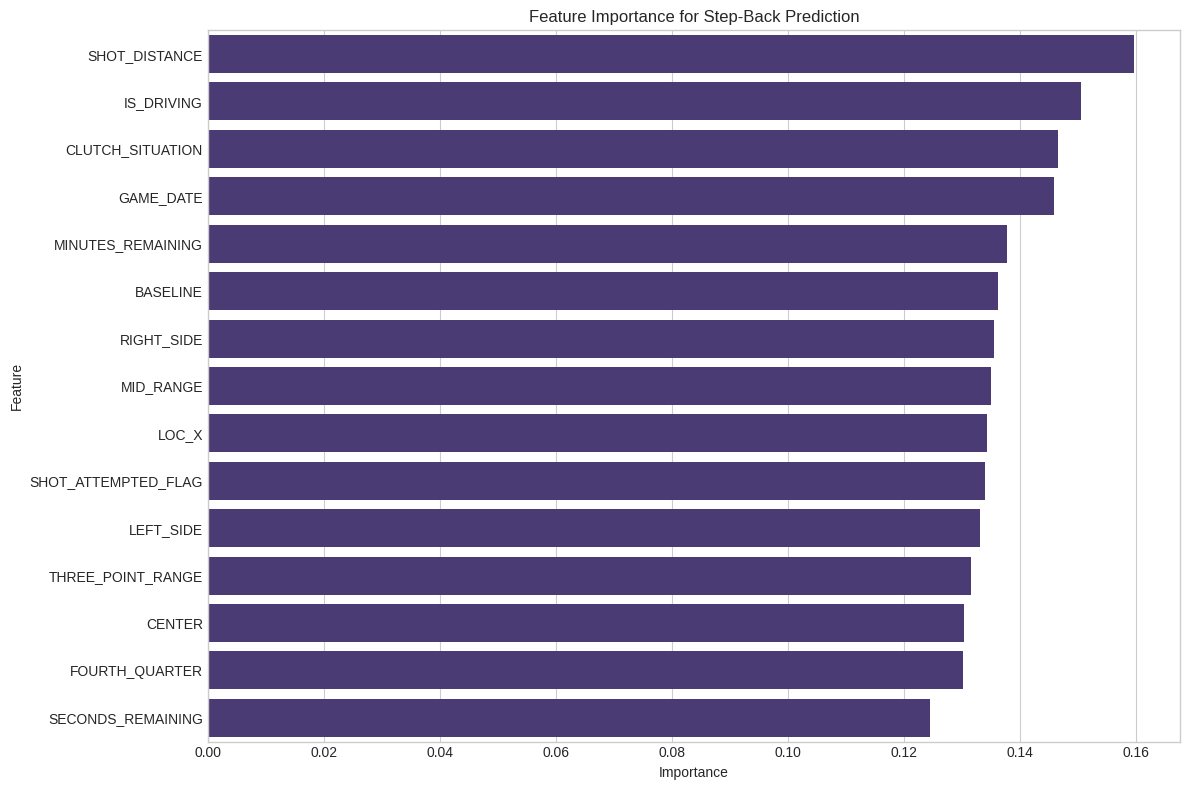

In [ ]:
def build_step_back_model(model_data):
    """Build TensorFlow model to predict step-back jumper usage"""
    if 'ACTION_TYPE' not in model_data.columns:
        print("Cannot build model: missing ACTION_TYPE column")
        return None

    # Create step-back indicator if not exists
    if 'IS_STEP_BACK' not in model_data.columns:
        model_data['IS_STEP_BACK'] = model_data['ACTION_TYPE'].str.contains('Step Back', case=False, na=False).astype(int)

    # Check if we have enough step-back jumpers
    step_back_count = model_data['IS_STEP_BACK'].sum()
    if step_back_count < 50:
        print(f"Only {step_back_count} step-back jumpers found - insufficient for modeling")
        return None, None

    print(f"\nBuilding model to predict step-back jumper usage (found {step_back_count} instances)...")

    # Define target and features
    y = model_data['IS_STEP_BACK']

    # Select only numeric features
    X = model_data.select_dtypes(include=['number'])

    # Remove target and ID columns
    exclude_cols = ['IS_STEP_BACK', 'GAME_ID', 'PLAYER_ID', 'TEAM_ID',
                   'GAME_EVENT_ID', 'SHOT_MADE_FLAG']
    feature_cols = [col for col in X.columns if col not in exclude_cols]
    X = X[feature_cols]

    # Split data with stratification (important for imbalanced data)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build model with class_weight to handle imbalance
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Calculate class weights for imbalanced data
    neg_count = len(y_train) - sum(y_train)
    pos_count = sum(y_train)
    weight_for_0 = (1 / neg_count) * len(y_train) / 2
    weight_for_1 = (1 / pos_count) * len(y_train) / 2
    class_weight = {0: weight_for_0, 1: weight_for_1}

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
        class_weight=class_weight,
        verbose=1
    )

    # Evaluate
    y_pred_prob = model.predict(X_test_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    weights = model.layers[0].get_weights()[0]
    importance = np.abs(weights).mean(axis=1)
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Features for Step-Back Prediction:")
    print(feature_importance.head(10))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Feature Importance for Step-Back Prediction')
    plt.tight_layout()
    plt.savefig('harden_analysis/step_back_features.png')
    plt.show()

    return model, feature_importance

# Build the step-back jumper model
step_back_model, step_back_importance = build_step_back_model(model_data)